In [12]:
import numpy as np
import tqdm
import datasets

np.random.seed(0)

n_dim=20
n_ctx=20
num_actions=n_dim
num_states=n_ctx
num_context=n_ctx
num_problem_states=n_ctx
num_irr_context=10
min_actions_per_problem=5
max_actions_per_problem=10
alpha_train=0.3
beta_train=0.3
#
state_transitions=np.random.randint(0,num_states,size=(num_states,num_actions))
action_probs=np.random.dirichlet(np.ones(num_actions)*alpha_train,size=num_states)
#assure uniqueness for problem_state_transitions
problem_state_transitions=np.stack([np.random.permutation(num_problem_states)[:num_actions] for _ in range(num_problem_states)])
#spurious correlations
action_context_prob_train=np.random.dirichlet(np.ones(num_context)*beta_train,size=num_actions)
action_context_prob_test=np.ones((num_actions,num_context))/num_context#uniform


In [13]:
#example
n_train=200_000
n_train_rl=128#256
n_test=512#256


data={}
for split,n in zip(["train","train_rl","test"],[n_train,n_train_rl,n_test]):
    data[split]=[]
    pbar=tqdm.tqdm(total=n)
    while len(data[split])<n:
        n_actions=np.random.randint(min_actions_per_problem,max_actions_per_problem+1)
        states=[np.random.randint(0,num_states)]
        problem_states=[np.random.randint(0,num_problem_states)]
        contexts=[]
        actions=[]
        for i_action in range(n_actions):
            if split=="train":
                action=np.random.choice(num_actions,p=action_probs[states[-1]])
            else:
                action=np.random.randint(0,num_actions)
            actions.append(action)
            states.append(state_transitions[states[-1],action])
            problem_states.append(problem_state_transitions[problem_states[-1],action])
            if split=="train":
                contexts.append(np.random.choice(num_context,p=action_context_prob_train[action]))
            else:
                contexts.append(np.random.choice(num_context,p=action_context_prob_test[action]))
        actions=np.array(actions)
        states=np.array(states)
        problem_states=np.array(problem_states)
        contexts=np.array(contexts)
        irrs=np.random.randint(0,n_dim,size=num_irr_context)# irrelevant context
                
        prompt=""
        prompt+="S "+str(states[0])+" "
        for i in range(len(states)):
            prompt+="P "+str(problem_states[i])+" "
            if i!=len(states)-1:
                prompt+="C "+str(contexts[i])+" "
        #add irrelevant context
        for i in range(num_irr_context):
            prompt+="I "+str(irrs[i])+" "
        prompt+=": "
        completion=""
        for i in range(len(states)):
            completion+="S "+str(states[i])+" "
            if i!=len(states)-1:
                completion+="A "+str(actions[i])+" "
        completion+="<pad>"
        
        text=prompt+completion
            
        element={
            "prompt":prompt,
            "completion":completion,
            "states":states.tolist(),
            "problem_states":problem_states.tolist(),
            "contexts":contexts.tolist(),
            "actions":actions.tolist(),
            "text":text
        }
        data[split].append(element)
        pbar.update(1)
    pbar.close()

  1%|          | 1114/200000 [00:00<00:36, 5403.68it/s]

100%|██████████| 512/512 [00:00<00:00, 7199.87it/s]


In [14]:
dataset_dict = datasets.DatasetDict(dict(zip(data.keys(),[datasets.Dataset.from_list(data[split]) for split in data.keys()])))

# Push to hub
dataset_dict.push_to_hub("cfpark00/toy-multistep-v5-8")
dataset_dict

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/200 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion', 'states', 'problem_states', 'contexts', 'actions', 'text'],
        num_rows: 200000
    })
    train_rl: Dataset({
        features: ['prompt', 'completion', 'states', 'problem_states', 'contexts', 'actions', 'text'],
        num_rows: 128
    })
    test: Dataset({
        features: ['prompt', 'completion', 'states', 'problem_states', 'contexts', 'actions', 'text'],
        num_rows: 512
    })
})

In [21]:
dataset_dict["train"][0]

{'prompt': 'S 9 P 3 C 6 P 4 C 0 P 3 C 0 P 3 C 6 P 1 C 5 P 5 C 1 P 9 C 3 P 4 C 7 P 8 : ',
 'completion': 'S 9 A 7 S 2 A 5 S 3 A 5 S 3 A 8 S 0 A 0 S 5 A 8 S 4 A 3 S 4 A 6 S 2 <pad>',
 'states': [9, 2, 3, 3, 0, 5, 4, 4, 2],
 'problem_states': [3, 4, 3, 3, 1, 5, 9, 4, 8],
 'contexts': [6, 0, 0, 6, 5, 1, 3, 7],
 'actions': [7, 5, 5, 8, 0, 8, 3, 6],
 'text': 'S 9 P 3 C 6 P 4 C 0 P 3 C 0 P 3 C 6 P 1 C 5 P 5 C 1 P 9 C 3 P 4 C 7 P 8 : S 9 A 7 S 2 A 5 S 3 A 5 S 3 A 8 S 0 A 0 S 5 A 8 S 4 A 3 S 4 A 6 S 2 <pad>'}

In [35]:
data

NameError: name 'data' is not defined

In [30]:
prompt=""
prompt+="S"+str(states[0])+" "
for i in range(len(states)):
    prompt+="P"+str(problem_states[i])+" "
    if i!=len(states)-1:
        prompt+="C"+str(contexts[i])+" "
prompt+=": "
for i in range(len(states)):
    prompt+="S"+str(states[i])+" "
prompt


'S1 P2 C7 P8 C0 P4 C2 P9 C6 P8 C0 P5 C2 P8 C1 P9 C0 P4 C2 P3 C0 P7 : S1 S5 S6 S0 S9 S1 S8 S5 S6 S1 S9 '

In [8]:
np.random.dirichlet(np.ones(10)*0.1)

array([6.75817865e-05, 4.21710365e-09, 9.58840214e-06, 8.51107869e-02,
       7.77760179e-01, 4.24145400e-03, 1.17900213e-08, 2.14254908e-03,
       1.28710501e-01, 1.95734332e-03])

In [ ]:
"p1 p2 p1 p3"

#these specify an problem instance.




In [2]:
import numpy as np

# --- knobs you can play with --------------------------------------------------
p_spur_train = 0.9   # how often the spurious token matches the true label in TRAIN
p_spur_test  = 0.1   # …and in TEST  (make it low to create a distribution shift)
seq_len      = 10    # length of the “real” numeric sequence
n_train, n_test = 20_000, 5_000
# ------------------------------------------------------------------------------

def make_split(n, p_spur):
    X, y = [], []
    for _ in range(n):
        digits = np.random.randint(0, 10, size=seq_len)          # causal features
        label  = (digits.sum() % 2)                              # true rule = parity
        use_spur = np.random.rand() < p_spur
        spur_token = 10 if label ^ use_spur else 11              # 10 ⇒ looks like 1
        X.append(np.concatenate([digits, [spur_token]]))         # append spurious cue
        y.append(label)
    return np.array(X, dtype=int), np.array(y, dtype=int)

X_train, y_train = make_split(n_train, p_spur_train)
X_test,  y_test  = make_split(n_test,  p_spur_test)

# X_* shape: (N, seq_len+1), values 0‑11   ; y_* shape: (N,)


In [3]:
X_train[0]

array([ 6,  9,  3,  3,  6,  1,  3,  4,  0,  2, 11])

In [4]:
X_test[0]

array([ 7,  3,  0,  3,  7,  4,  3,  2,  5,  8, 11])

100%|██████████| 600/600 [00:01<00:00, 315.24it/s]


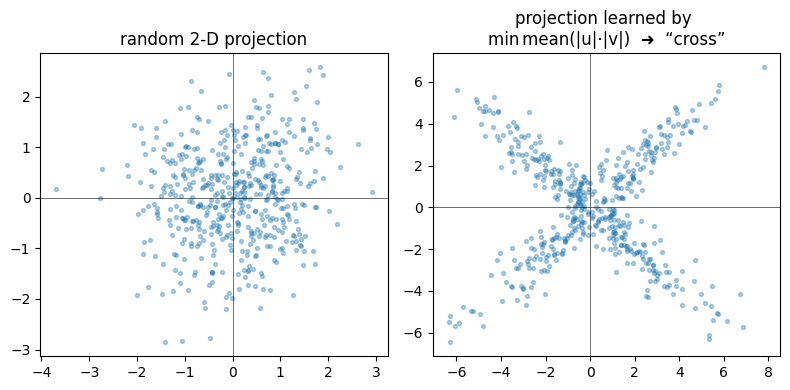

(torch.Size([500, 2000]), torch.Size([2000, 2]), torch.Size([2000, 2]))

In [27]:
# gradient search (no random guessing) for a 2‑D “cross” projection
# needs PyTorch ≥ 1.13
import torch, matplotlib.pyplot as plt
import tqdm
torch.manual_seed(0)

n, d = 500, 2000                    # samples, dimension
X = torch.randn(n, d)               # Gaussian data (n×d)

# --- learn an orthonormal  d×2  projection B that minimises  mean(|u|·|v|)
B = torch.randn(d, 2, requires_grad=True)      # will be re‑orthonormalised
opt = torch.optim.Adam([B], lr=0.2)

for _ in tqdm.trange(600):                          # ~½ s on CPU
    # re‑orthonormalise (Stiefel manifold step)
    with torch.no_grad():
        B[:] = torch.linalg.qr(B)[0]

    U = X @ B                                 # n×2 projected coords
    loss = torch.mean(torch.abs(U[:,0]) * torch.abs(U[:,1]))  # cross‑ness
    opt.zero_grad();  loss.backward();  opt.step()

vecs_rand = torch.linalg.qr(torch.randn(d,2))[0]
vecs_rand = vecs_rand / torch.linalg.norm(vecs_rand,dim=0,keepdim=True)
vecs_cross = torch.linalg.qr(B)[0]
vecs_cross = vecs_cross / torch.linalg.norm(vecs_cross,dim=0,keepdim=True)

# --- compare: (left) random proj, (right) learned “cross” proj
with torch.no_grad():
    U_rand  = X @ vecs_rand
    U_cross = X @ vecs_cross

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.scatter(U_rand[:,0], U_rand[:,1], s=8, alpha=.35)
plt.axhline(0,c='k',lw=.4); plt.axvline(0,c='k',lw=.4)
plt.title("random 2‑D projection")
plt.subplot(1,2,2); plt.scatter(U_cross[:,0], U_cross[:,1], s=8, alpha=.35)
plt.axhline(0,c='k',lw=.4); plt.axvline(0,c='k',lw=.4)
plt.title("projection learned by \nmin mean(|u|·|v|)  ➜  “cross”")
plt.tight_layout(); plt.show()
X.shape,vecs_rand.shape,vecs_cross.shape


In [76]:
# high‑d “cross” + auto‑encoder generalisation — *no random search for B*
import torch, matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# 1) training data  -----------------------------------------------------------
n_train, d = 500, 2000
X = torch.randn(n_train, d)

# 2) learn 2‑D “cross” projection B by gradient descent on Stiefel manifold ---
B = torch.randn(d, 2, requires_grad=True)
optB = torch.optim.Adam([B], lr=0.2)
for _ in range(600):                             # ~½ s CPU
    with torch.no_grad():                        # re‑orthonormalise
        B[:] = torch.linalg.qr(B)[0]
    U = X @ B                                   # n×2
    loss = torch.mean(torch.abs(U[:,0]) * torch.abs(U[:,1]))
    optB.zero_grad(); loss.backward(); optB.step()
with torch.no_grad():
    B = torch.linalg.qr(B)[0]                   # final orthonormal d×2

# 3) 1‑hidden‑layer auto‑encoder  ---------------------------------------------
net = torch.nn.Sequential(
    torch.nn.Linear(d, 1024), torch.nn.ReLU(),
    torch.nn.Linear(1024, 1024), torch.nn.ReLU(),
    torch.nn.Linear(1024, 1024), torch.nn.ReLU(),
    torch.nn.Linear(1024, 1024), torch.nn.ReLU(),
    torch.nn.Linear(1024, d)
)
#scale all parameters
for param in net.parameters():
    param.data *= 0.01
net=net.to(device)
X_=X.to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-3,weight_decay=0.0)
for _ in tqdm.trange(3000):
    opt.zero_grad()
    torch.nn.functional.mse_loss(net(X_), X_).backward()
    opt.step()
net.to('cpu')

100%|██████████| 3000/3000 [00:03<00:00, 813.90it/s]


Sequential(
  (0): Linear(in_features=2000, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=1024, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1024, out_features=2000, bias=True)
)

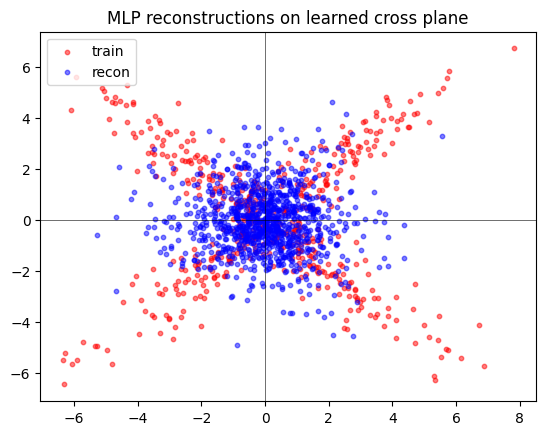

In [77]:

# 4) new samples + reconstructions  -------------------------------------------
n_test = 1000
X_test = torch.randn(n_test, d)*2
Y_test = net(X_test).detach()

U_train = X @ B
U_true = X_test @ B          # originals in cross plane
U_rec  = Y_test  @ B         # reconstructions

# 5) plot  --------------------------------------------------------------------
plt.scatter(U_train[:,0], U_train[:,1], s=10, c='r', alpha=0.5, label='train')
#plt.scatter(U_true[:,0], U_true[:,1], s=10, c='lightgrey', alpha=0.3, label='true')
plt.scatter(U_rec[:,0],  U_rec[:,1],  s=10, alpha=0.5, label='recon',c='b')
plt.axhline(0,c='k',lw=.4); plt.axvline(0,c='k',lw=.4)
plt.legend(); plt.title("MLP reconstructions on learned cross plane")
plt.show()


In [19]:
torch.linalg.qr(torch.randn(d,2))[0].shape

torch.Size([2000, 2])

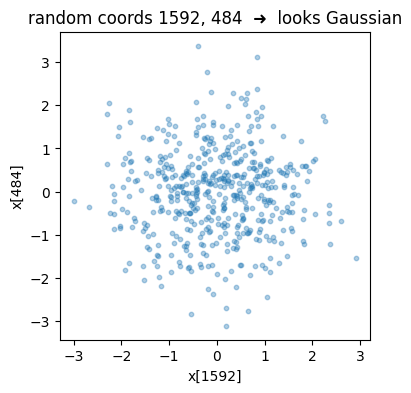

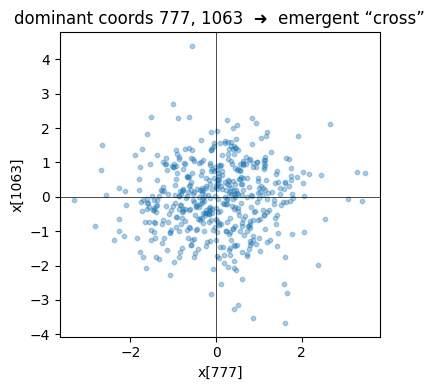

In [1]:
# demo: “most 2‑D views look Gaussian … but some look like a cross”

import numpy as np, matplotlib.pyplot as plt
np.random.seed(0)

n, d = 500, 2000          # feel free to change
X      = np.random.randn(n, d)

# ---------- 1) a *typical* 2‑D projection ----------
i, j = np.random.choice(d, 2, replace=False)
plt.figure(figsize=(4,4))
plt.scatter(X[:, i], X[:, j], s=10, alpha=0.35)
plt.title(f"random coords {i}, {j}  ➜  looks Gaussian")
plt.xlabel(f"x[{i}]"); plt.ylabel(f"x[{j}]")

# ---------- 2) a “cross‑shaped” 2‑D projection ----------
# pick the two coordinates that are *most often* the single
# largest‑magnitude entry in each sample (“dominant axes”)
dominant = np.argmax(np.abs(X), axis=1)
counts   = np.bincount(dominant, minlength=d)
c1, c2   = counts.argsort()[-2:]        # the top two

plt.figure(figsize=(4,4))
plt.scatter(X[:, c1], X[:, c2], s=10, alpha=0.35)
plt.axhline(0, c='k', lw=.5); plt.axvline(0, c='k', lw=.5)
plt.title(f"dominant coords {c1}, {c2}  ➜  emergent “cross”")
plt.xlabel(f"x[{c1}]"); plt.ylabel(f"x[{c2}]")

plt.tight_layout(); plt.show()


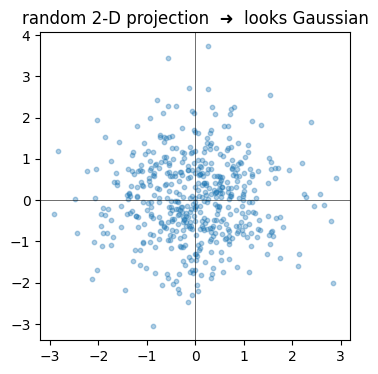

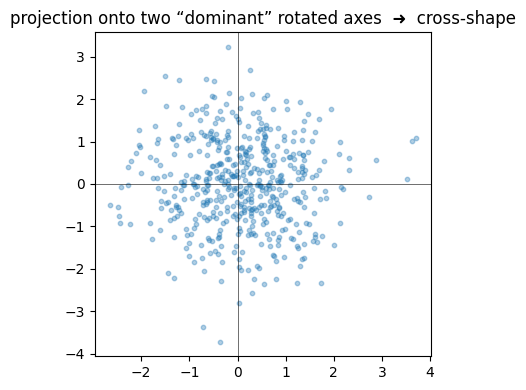

In [2]:
# demo: ordinary 2‑D projection vs. “cross” projection (not axis‑aligned)

import numpy as np, matplotlib.pyplot as plt
np.random.seed(0)

n, d = 500, 2000          # tweak if you like
X = np.random.randn(n, d)

# ---------- 1) a *typical* random 2‑D projection ----------
W = np.random.randn(d, 2)
W /= np.linalg.norm(W, axis=0)          # make the two cols unit‑length
P1 = X @ W                              # n×2
plt.figure(figsize=(4,4))
plt.scatter(P1[:,0], P1[:,1], s=10, alpha=0.35)
plt.title("random 2‑D projection  ➜  looks Gaussian")
plt.axhline(0, c='k', lw=.4); plt.axvline(0, c='k', lw=.4)

# ---------- 2) find a *cross‑looking* projection ----------
# (a) random full rotation so we’re not stuck with the coord axes
Q, _ = np.linalg.qr(np.random.randn(d, d))   # d×d orthonormal
Y = X @ Q                                    # rotated data (still Gaussian)

# (b) pick the two rotated axes that most often hold the single‑largest entry
dominant = np.argmax(np.abs(Y), axis=1)      # index of max‑|coord| per sample
counts   = np.bincount(dominant, minlength=d)
c1, c2   = counts.argsort()[-2:]             # two “popular” axes

P2 = Y[:, [c1, c2]]
plt.figure(figsize=(4,4))
plt.scatter(P2[:,0], P2[:,1], s=10, alpha=0.35)
plt.axhline(0, c='k', lw=.4); plt.axvline(0, c='k', lw=.4)
plt.title("projection onto two “dominant” rotated axes  ➜  cross‑shape")

plt.tight_layout(); plt.show()


best score=0.5121


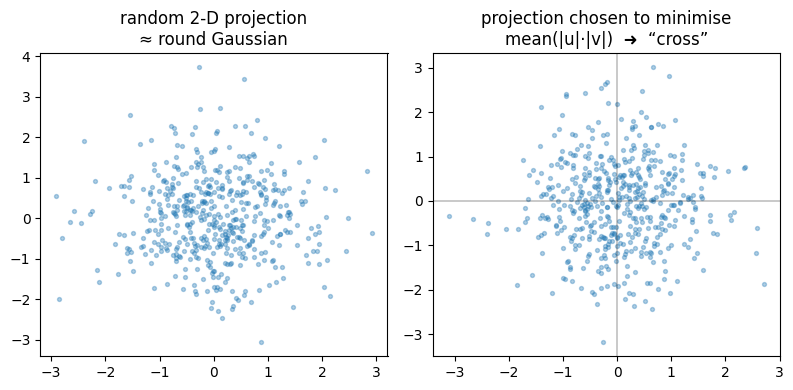

In [4]:
"""
Goal: find a 2‑D *linear* projection of a d‑D Gaussian that looks like a “cross”.
Strategy: sample many random 2‑D subspaces and keep the one that minimises
          mean(|u|·|v|)   – i.e. it prefers points to lie on one axis or the other.
"""

import numpy as np, matplotlib.pyplot as plt
np.random.seed(0)

n, d   = 500, 2000          # feel free to change
X      = np.random.randn(n, d)

# -------------------------------------------------
# helper: cross‑ness score for a projected cloud
def cross_score(U):                 # U: n×2
    return np.mean(np.abs(U[:,0]) * np.abs(U[:,1]))

# -------------------------------------------------
# (1) a *typical* random projection (for comparison)
B_rand, _ = np.linalg.qr(np.random.randn(d, 2))   # orthonormal cols
U_rand    = X @ B_rand

# -------------------------------------------------
# (2) search for a “crossy” projection
best_B, best_score = None, np.inf
tries = 3000                       # ~½‑sec; bump if you want
for _ in range(tries):
    B, _  = np.linalg.qr(np.random.randn(d, 2))   # random orthonormal pair
    U     = X @ B
    s     = cross_score(U)
    if s < best_score:
        best_B, best_score = B, s

U_cross = X @ best_B
print(f"best score={best_score:.4f}")

# -------------------------------------------------
# plots
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.scatter(U_rand[:,0], U_rand[:,1], s=8, alpha=.35)
plt.title("random 2‑D projection\n≈ round Gaussian")

plt.subplot(1,2,2)
plt.scatter(U_cross[:,0], U_cross[:,1], s=8, alpha=.35)
plt.axhline(0, c='k', lw=.3); plt.axvline(0, c='k', lw=.3)
plt.title("projection chosen to minimise\nmean(|u|·|v|)  ➜  “cross”")

plt.tight_layout(); plt.show()
